In [1]:
# Improved Document Forgery Detection Model
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision import transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from preprocessing import apply_clahe, apply_hsv_equalization, apply_lthe
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import copy
from PIL import Image
import easyocr
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

torch.backends.cudnn.benchmark = True

/home/hasan/anaconda3/envs/gpu_ml/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/hasan/anaconda3/envs/gpu_ml/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/hasan/anaconda3/envs/gpu_ml/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/hasan/anaconda3/envs/gpu_ml/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
class EnhancedDocumentDataset(Dataset):
    def __init__(self, samples, transform=None, use_ocr=False):
        self.samples = samples
        self.transform = transform
        self.use_ocr = use_ocr
        if use_ocr:
            self.ocr_reader = easyocr.Reader(['en'])
    
    def __len__(self):
        return len(self.samples)
    
    def extract_text_features(self, img):
        """Extract text-based features that might indicate forgery"""
        try:
            results = self.ocr_reader.readtext(img)
            text_features = []
            
            for (bbox, text, confidence) in results:
                # Extract bounding box coordinates
                x1, y1 = int(min([point[0] for point in bbox])), int(min([point[1] for point in bbox]))
                x2, y2 = int(max([point[0] for point in bbox])), int(max([point[1] for point in bbox]))
                
                # Extract text region
                text_region = img[y1:y2, x1:x2]
                if text_region.size > 0:
                    # Analyze text region for potential forgery indicators
                    # Check for inconsistent font characteristics, blurriness, etc.
                    gray_region = cv2.cvtColor(text_region, cv2.COLOR_BGR2GRAY)
                    
                    # Calculate sharpness (Laplacian variance)
                    sharpness = cv2.Laplacian(gray_region, cv2.CV_64F).var()
                    
                    # Calculate edge density
                    edges = cv2.Canny(gray_region, 50, 150)
                    edge_density = np.sum(edges > 0) / edges.size
                    
                    text_features.extend([confidence, sharpness, edge_density])
            
            # Pad or truncate to fixed size
            target_size = 20  # 10 text regions * 3 features each
            if len(text_features) < target_size:
                text_features.extend([0.0] * (target_size - len(text_features)))
            else:
                text_features = text_features[:target_size]
                
            return np.array(text_features, dtype=np.float32)
        except:
            return np.zeros(30, dtype=np.float32)
    
    def advanced_preprocessing(self, img, path):
        """Enhanced preprocessing pipeline"""
        # Apply different preprocessing based on document type
        if "ID" in path:
            # Enhanced preprocessing for ID documents
            img = apply_clahe(img)
            img = apply_hsv_equalization(img)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mask = apply_lthe(gray)
            img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        
        # Additional preprocessing for better feature extraction
        # Enhance contrast
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel = lab[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l_channel = clahe.apply(l_channel)
        lab[:,:,0] = l_channel
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
        # Noise reduction
        img = cv2.bilateralFilter(img, 5, 50, 50)
        
        return img
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        
        # Apply advanced preprocessing
        img = self.advanced_preprocessing(img, path)
        
        # Extract text features if OCR is enabled
        text_features = None
        if self.use_ocr:
            text_features = self.extract_text_features(img)
        
        if self.transform:
            img = self.transform(img)
        
        if text_features is not None:
            return img, torch.tensor(text_features), label
        else:
            return img, label

In [3]:
class ImprovedConvNextModel(nn.Module):
    def __init__(self, num_classes=2, use_text_features=False, dropout_rate=0.3):
        super(ImprovedConvNextModel, self).__init__()
        
        # Load pretrained ConvNeXt
        self.backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        
        # Remove the original classifier
        self.features = self.backbone.features
        self.avgpool = self.backbone.avgpool
        
        # Enhanced classifier with additional layers
        feature_dim = 768
        self.use_text_features = use_text_features
        
        if use_text_features:
            # Text feature processor
            self.text_processor = nn.Sequential(
                nn.Linear(30, 64),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            feature_dim += 32
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, text_features=None):
        # Extract visual features
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # Combine with text features if available
        if self.use_text_features and text_features is not None:
            text_feat = self.text_processor(text_features)
            x = torch.cat([x, text_feat], dim=1)
        
        x = self.classifier(x)
        return x

In [4]:
def get_enhanced_model(device, use_text_features=False, dropout_rate=0.3):
    model = ImprovedConvNextModel(
        num_classes=2, 
        use_text_features=use_text_features,
        dropout_rate=dropout_rate
    )
    return model.to(device)


In [5]:
def get_split_datasets(root_dir, doc_types, transform, use_ocr=False):
    all_samples = []
    for doc_type in doc_types:
        for label in ["Real", "Forged"]:
            img_dir = os.path.join(root_dir, doc_type, label, "Images")
            if os.path.exists(img_dir):
                for fname in os.listdir(img_dir):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        path = os.path.join(img_dir, fname)
                        lbl = 0 if label == "Real" else 1
                        all_samples.append((path, lbl))

    # Stratified split
    train_val, test = train_test_split(
        all_samples, test_size=0.15, 
        stratify=[s[1] for s in all_samples], 
        random_state=42
    )
    train, val = train_test_split(
        train_val, test_size=0.15 / 0.85, 
        stratify=[s[1] for s in train_val], 
        random_state=42
    )

    train_ds = EnhancedDocumentDataset(train, transform, use_ocr)
    val_ds = EnhancedDocumentDataset(val, transform, use_ocr)
    test_ds = EnhancedDocumentDataset(test, transform, use_ocr)

    return train_ds, val_ds, test_ds

In [6]:
def train_enhanced_forgery_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Enhanced data augmentation
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    doc_types = ["budget", "ID", "invoice", "form", "memo", "letter"]
    
    # Try with OCR features (set to False if easyocr is not available)
    use_ocr = True
    try:
        import easyocr
    except ImportError:
        print("EasyOCR not available, using visual features only")
        use_ocr = False
    
    # Get datasets with different transforms for train/val
    train_ds, _, _ = get_split_datasets("/home/hasan/datasets/datasets", doc_types, train_transform, use_ocr)
    _, val_ds, test_ds = get_split_datasets("/home/hasan/datasets/datasets", doc_types, val_transform, use_ocr)

    # Data loaders with better configurations
    train_loader = DataLoader(
        train_ds, batch_size=32, shuffle=True, 
        pin_memory=True, num_workers=6, 
        persistent_workers=True, drop_last=True, prefetch_factor=4
    )
    val_loader = DataLoader(
        val_ds, batch_size=32, shuffle=False, 
        pin_memory=True, num_workers=4
    )
    test_loader = DataLoader(
        test_ds, batch_size=16, shuffle=False, 
        pin_memory=True, num_workers=4
    )

    # Enhanced model
    model = get_enhanced_model(device, use_text_features=use_ocr, dropout_rate=0.4)
    
    # Improved loss function with label smoothing
    class LabelSmoothingLoss(nn.Module):
        def __init__(self, smoothing=0.1):
            super().__init__()
            self.smoothing = smoothing
        
        def forward(self, pred, target):
            confidence = 1.0 - self.smoothing
            log_probs = torch.log_softmax(pred, dim=1)
            nll_loss = -log_probs.gather(dim=1, index=target.unsqueeze(1)).squeeze(1)
            smooth_loss = -log_probs.mean(dim=1)
            loss = confidence * nll_loss + self.smoothing * smooth_loss
            return loss.mean()
    
    criterion = LabelSmoothingLoss(smoothing=0.1)
    
    # Improved optimizer with different learning rates for backbone and classifier
    backbone_params = list(model.features.parameters())
    classifier_params = list(model.classifier.parameters())
    if use_ocr:
        classifier_params.extend(list(model.text_processor.parameters()))
    
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': 2e-5, 'weight_decay': 1e-4},
        {'params': classifier_params, 'lr': 5e-4, 'weight_decay': 1e-3}
    ])
    
    # Mixed precision training
    scaler = torch.amp.GradScaler('cuda')
    
    # Improved scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-7)
    
    # Training tracking
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience = 8
    wait = 0

    print("Starting enhanced training...")
    for epoch in range(30):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/30", leave=False)
        for batch_data in progress_bar:
            if use_ocr:
                images, text_features, labels = batch_data
                text_features = text_features.to(device, non_blocking=True)
            else:
                images, labels = batch_data
                text_features = None
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            
            with torch.amp.autocast('cuda'):
                outputs = model(images, text_features)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            
            if total_train % 128 == 0:  # Update every 128 samples
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * correct_train / total_train:.2f}%'
                })

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch_data in val_loader:
                if use_ocr:
                    images, text_features, labels = batch_data
                    text_features = text_features.to(device)
                else:
                    images, labels = batch_data
                    text_features = None
                
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.amp.autocast('cuda'):
                    outputs = model(images, text_features)
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        
        # Update scheduler
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            wait = 0
            print(f"New best validation accuracy: {best_val_acc:.2f}%")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "enhanced_forgery_model_best.pth")
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    print("Enhanced training complete.")
    torch.cuda.empty_cache()
    return test_loader, model, use_ocr

In [7]:
def evaluate_enhanced_model(model_path, test_loader, device, use_ocr=False):
    model = get_enhanced_model(device, use_text_features=use_ocr)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_data in tqdm(test_loader, desc="Evaluating"):
            if use_ocr:
                images, text_features, labels = batch_data
                text_features = text_features.to(device)
            else:
                images, labels = batch_data
                text_features = None
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images, text_features)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Forged']))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Forged'], 
                yticklabels=['Real', 'Forged'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy

Using device: cuda
Starting enhanced training...


Epoch 1/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 0.8658 | Train Acc: 51.56% | Val Loss: 0.6789 | Val Acc: 55.48% | LR: 1.99e-05
New best validation accuracy: 55.48%


Epoch 2/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 0.7064 | Train Acc: 53.32% | Val Loss: 0.6786 | Val Acc: 52.13% | LR: 1.98e-05


Epoch 3/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 0.6856 | Train Acc: 53.68% | Val Loss: 0.6757 | Val Acc: 55.41% | LR: 1.95e-05


Epoch 4/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 0.6825 | Train Acc: 55.16% | Val Loss: 0.6750 | Val Acc: 56.79% | LR: 1.91e-05
New best validation accuracy: 56.79%


Epoch 5/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 0.6808 | Train Acc: 55.28% | Val Loss: 0.6679 | Val Acc: 60.43% | LR: 1.87e-05
New best validation accuracy: 60.43%


Epoch 6/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 0.6197 | Train Acc: 67.66% | Val Loss: 0.5537 | Val Acc: 74.61% | LR: 1.81e-05
New best validation accuracy: 74.61%


Epoch 7/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 0.5723 | Train Acc: 73.26% | Val Loss: 0.5344 | Val Acc: 76.37% | LR: 1.74e-05
New best validation accuracy: 76.37%


Epoch 8/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 0.5516 | Train Acc: 75.15% | Val Loss: 0.5250 | Val Acc: 77.37% | LR: 1.67e-05
New best validation accuracy: 77.37%


Epoch 9/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 0.5378 | Train Acc: 76.49% | Val Loss: 0.5167 | Val Acc: 77.92% | LR: 1.59e-05
New best validation accuracy: 77.92%


Epoch 10/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.5252 | Train Acc: 77.51% | Val Loss: 0.5057 | Val Acc: 78.99% | LR: 1.50e-05
New best validation accuracy: 78.99%


Epoch 11/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.5061 | Train Acc: 79.39% | Val Loss: 0.4984 | Val Acc: 79.90% | LR: 1.41e-05
New best validation accuracy: 79.90%


Epoch 12/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.4919 | Train Acc: 80.47% | Val Loss: 0.4847 | Val Acc: 81.35% | LR: 1.31e-05
New best validation accuracy: 81.35%


Epoch 13/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.4751 | Train Acc: 81.81% | Val Loss: 0.4755 | Val Acc: 82.11% | LR: 1.21e-05
New best validation accuracy: 82.11%


Epoch 14/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.4608 | Train Acc: 83.07% | Val Loss: 0.4631 | Val Acc: 83.06% | LR: 1.11e-05
New best validation accuracy: 83.06%


Epoch 15/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.4531 | Train Acc: 83.89% | Val Loss: 0.4665 | Val Acc: 83.15% | LR: 1.01e-05
New best validation accuracy: 83.15%


Epoch 16/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.4426 | Train Acc: 84.42% | Val Loss: 0.4621 | Val Acc: 83.11% | LR: 9.01e-06


Epoch 17/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.4370 | Train Acc: 84.88% | Val Loss: 0.4642 | Val Acc: 83.65% | LR: 7.98e-06
New best validation accuracy: 83.65%


Epoch 18/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.4303 | Train Acc: 85.18% | Val Loss: 0.4634 | Val Acc: 83.75% | LR: 6.98e-06
New best validation accuracy: 83.75%


Epoch 19/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.4225 | Train Acc: 85.81% | Val Loss: 0.4748 | Val Acc: 82.96% | LR: 6.00e-06


Epoch 20/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.4147 | Train Acc: 86.59% | Val Loss: 0.4694 | Val Acc: 82.75% | LR: 5.08e-06


Epoch 21/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.4109 | Train Acc: 86.52% | Val Loss: 0.4800 | Val Acc: 82.44% | LR: 4.20e-06


Epoch 22/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.4103 | Train Acc: 86.60% | Val Loss: 0.4796 | Val Acc: 82.44% | LR: 3.39e-06


Epoch 23/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.4037 | Train Acc: 87.04% | Val Loss: 0.4822 | Val Acc: 82.99% | LR: 2.66e-06


Epoch 24/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.4013 | Train Acc: 87.35% | Val Loss: 0.4829 | Val Acc: 82.70% | LR: 2.00e-06


Epoch 25/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.3958 | Train Acc: 87.63% | Val Loss: 0.4882 | Val Acc: 82.30% | LR: 1.43e-06


Epoch 26/30:   0%|          | 0/612 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.3934 | Train Acc: 87.84% | Val Loss: 0.4758 | Val Acc: 83.23% | LR: 9.60e-07
Early stopping triggered.


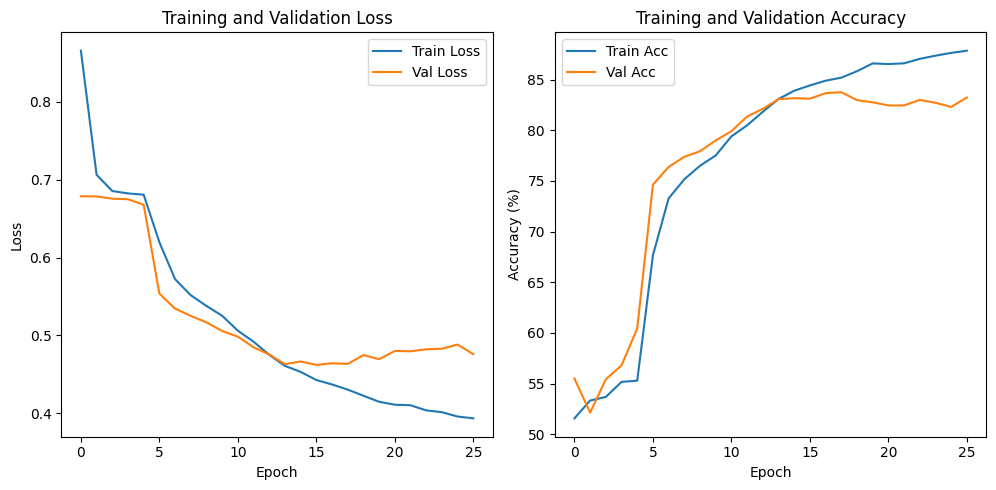

Enhanced training complete.


Evaluating:   0%|          | 0/263 [00:00<?, ?it/s]

Test Accuracy: 83.39%

Classification Report:
              precision    recall  f1-score   support

        Real       0.81      0.86      0.83      2017
      Forged       0.86      0.81      0.83      2186

    accuracy                           0.83      4203
   macro avg       0.83      0.84      0.83      4203
weighted avg       0.84      0.83      0.83      4203



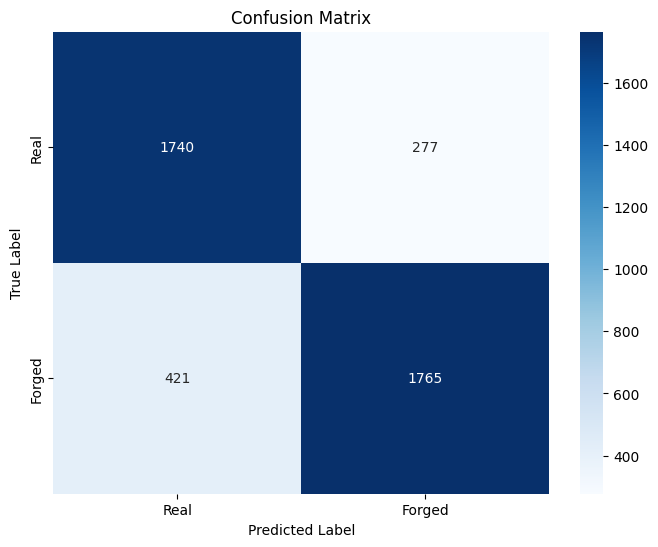

In [8]:
if __name__ == "__main__":
    test_loader, trained_model, use_ocr_flag = train_enhanced_forgery_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_enhanced_model("enhanced_forgery_model_best.pth", test_loader, device, use_ocr_flag)